In [30]:
import matplotlib.pyplot as plt
import numpy as np


def plot(out, edge_index):
    edges = edge_index
    plt.scatter(out[:, 0], out[:, 1], marker=".")
    for i in range(edges.shape[1]):
        src, dst = edges[:, i]
        plt.plot([out[src, 0], out[dst, 0]], [out[src, 1], out[dst, 1]], "red")
    plt.show()

## learngraph data

In [39]:
import pandas as pd
import torch

nodes = pd.read_csv("./lg-nodes.csv")
edges = pd.read_csv("./lg-edges.csv")

unique_nodes = pd.concat([edges["from_id"], edges["to_id"]]).unique()
node_to_index = {node_id: idx for idx, node_id in enumerate(unique_nodes)}
edges["from_index"] = edges["from_id"].map(node_to_index)
edges["to_index"] = edges["to_id"].map(node_to_index)
edge_index = torch.tensor(
    [edges["from_index"].to_numpy(), edges["to_index"].to_numpy()], dtype=torch.long
)

## Model definition

In [63]:
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch.nn.functional as F
import torch_geometric.nn as nn

x = torch.tensor([[i] for i in range(len(edge_index[0]))], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)


class GCN(torch.nn.Module):
    """Simple GCN model"""

    def __init__(self, mid=16):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, mid)  # First layer with 16 output dimensions
        self.conv2 = GCNConv(
            mid, 2
        )  # Second layer with 2 output dimensions (for 2D embedding)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Apply ReLU activation
        x = self.conv2(x, edge_index)
        return x

## Training

In [64]:
model = GCN()

Epoch 0, Loss: 59414576.0


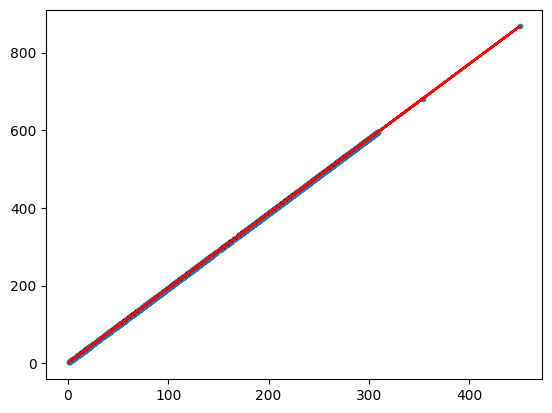

Epoch 20, Loss: 3317978.25


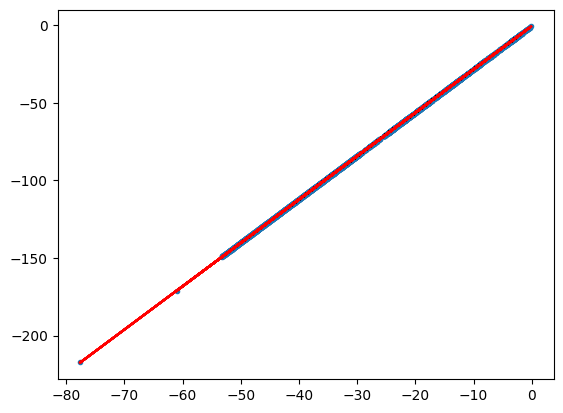

Epoch 40, Loss: 379255.4375


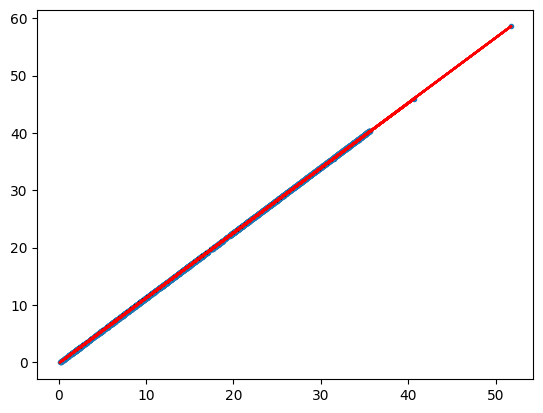

Epoch 60, Loss: 24273.86328125


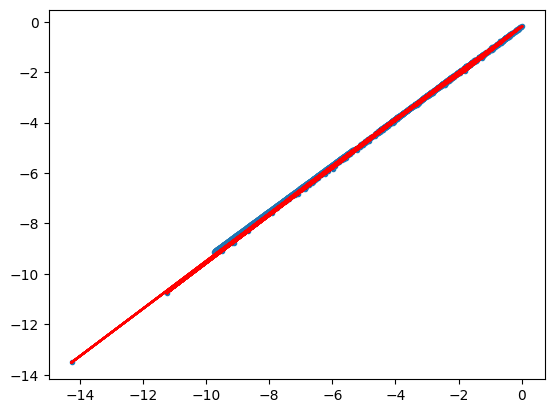

Epoch 80, Loss: 648.6610107421875


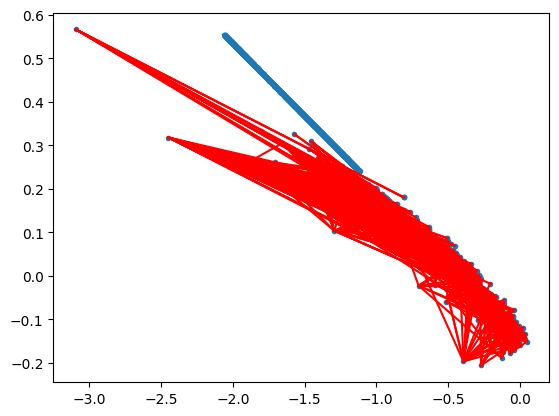

Epoch 100, Loss: 913.5610961914062


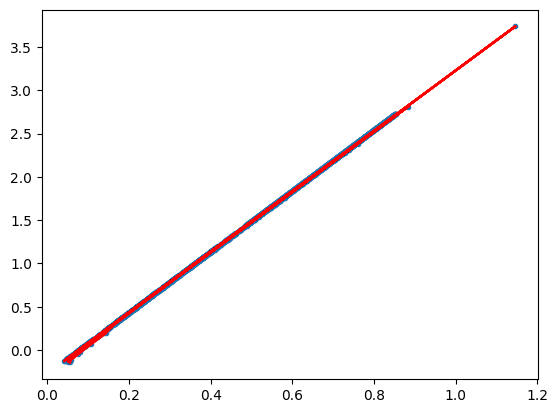

Epoch 120, Loss: 59.798561096191406


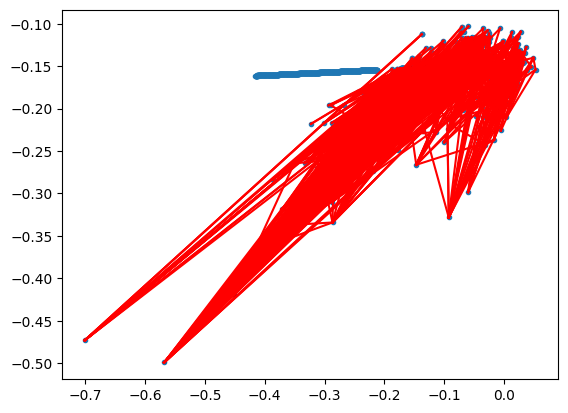

Epoch 140, Loss: 13.09453010559082


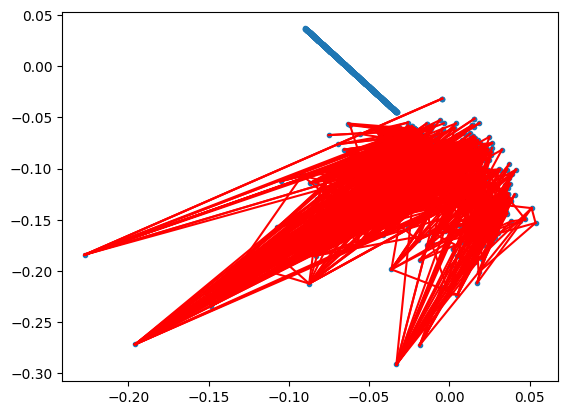

Epoch 160, Loss: 3.79114031791687


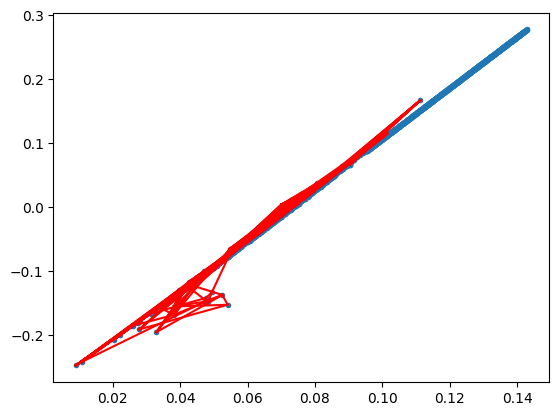

Epoch 180, Loss: 3.2763779163360596


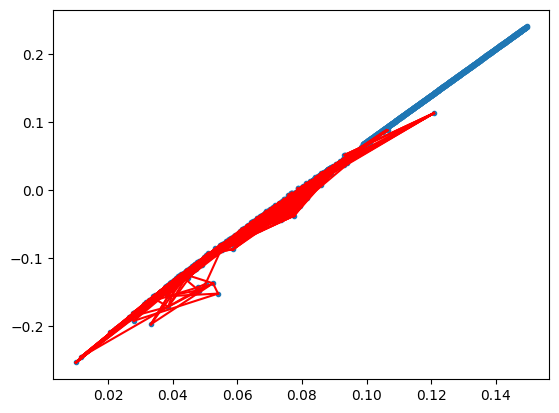

In [65]:
# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# sum up all distances between nodes that are connected by an edge
def edges_pull(output, edge_index):
    loss = torch.tensor(0.0, requires_grad=True)
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        dist_squared = torch.sum((output[src] - output[dst]) ** 2)
        loss = loss + dist_squared
    return loss


def edges_pull_nodes_push(
    output,
    edge_index,
    non_connected_pairs,
    threshold_connect=5.0,
    threshold_non_connect=30.0,
):
    loss = torch.tensor(0.0, requires_grad=True)
    # Calculate loss for connected nodes
    src, dst = edge_index
    dist = (output[src] - output[dst]) ** 2
    connected_loss = torch.sum(torch.exp(-dist[dist < threshold_connect**2]))
    connected_loss += torch.sum(
        (dist[dist >= threshold_connect**2] - threshold_connect**2) ** 2
    )
    # Calculate loss for non-connected nodes
    i, j = zip(*non_connected_pairs)
    i = torch.tensor(i, dtype=torch.long)
    j = torch.tensor(j, dtype=torch.long)
    dist_non_connected = torch.norm(output[i] - output[j], dim=1)
    non_connected_loss = torch.sum(
        F.leaky_relu(threshold_non_connect - dist_non_connected, negative_slope=0.01)
    )
    loss = loss + connected_loss + non_connected_loss
    return loss


def preprocess_non_connected_pairs(num_nodes, edge_index):
    connected_pairs = set()
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        connected_pairs.add((src.item(), dst.item()))
        connected_pairs.add((dst.item(), src.item()))
    non_connected_pairs = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if (i, j) not in connected_pairs and (j, i) not in connected_pairs:
                non_connected_pairs.append((i, j))
    return non_connected_pairs


non_connected_pairs = preprocess_non_connected_pairs(x.shape[0], edge_index)

# Training loop
epochs = 200
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    # loss = edges_pull_nodes_push(out, data.edge_index, non_connected_pairs)
    loss = edges_pull(out, data.edge_index)
    loss.backward()
    optimizer.step()
    if epoch % (epochs / 10) == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        plot(out.detach().numpy(), edge_index)

# Forward pass to get the final embeddings
model.eval()
with torch.no_grad():
    out = model(data)

out = out.detach().numpy()

Epoch 0, Loss: 3498337894400.0


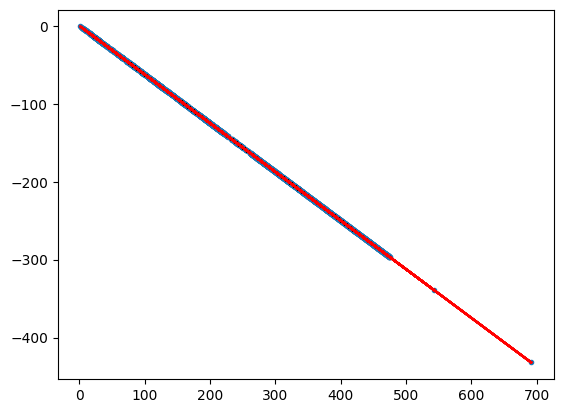

Epoch 20, Loss: 21109915648.0


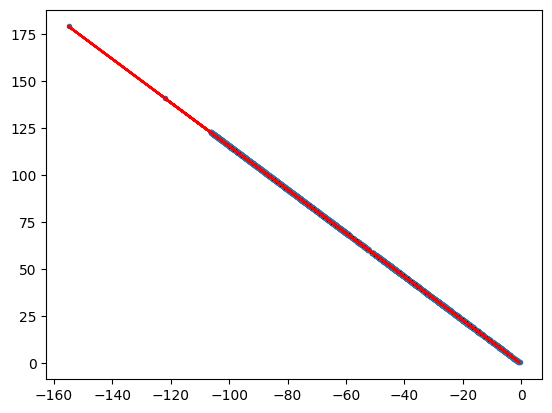

Epoch 40, Loss: 7546499072.0


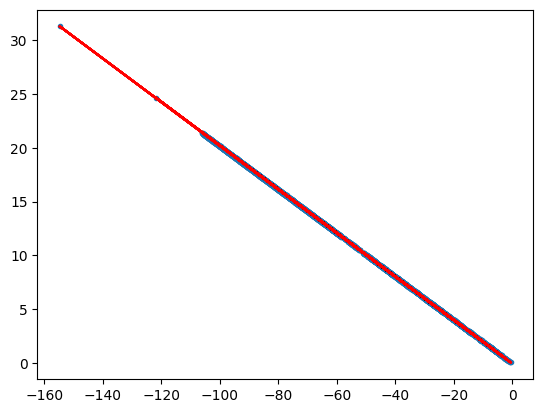

Epoch 60, Loss: 501047936.0


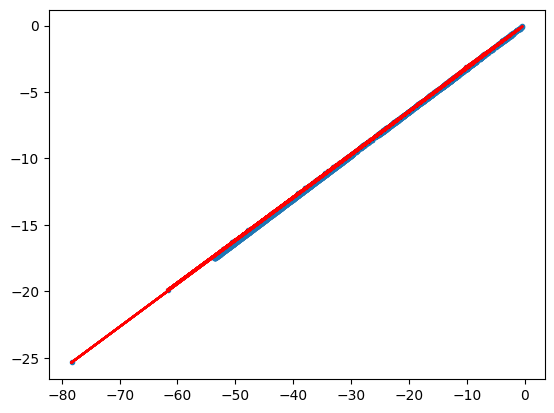

Epoch 80, Loss: 141470928.0


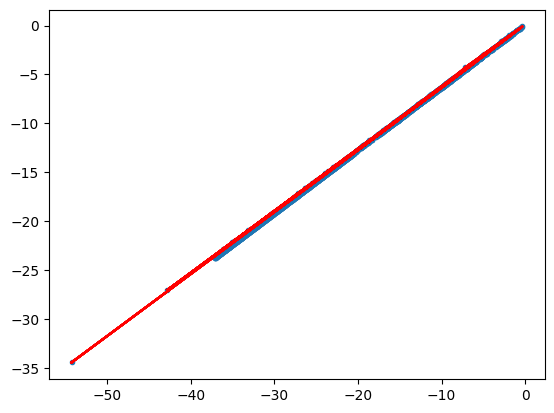

Epoch 100, Loss: 90432336.0


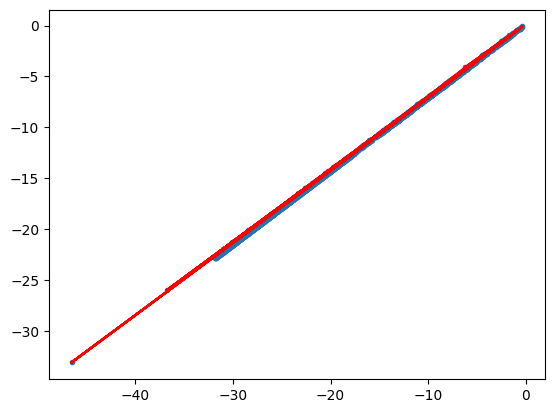

Epoch 120, Loss: 69889152.0


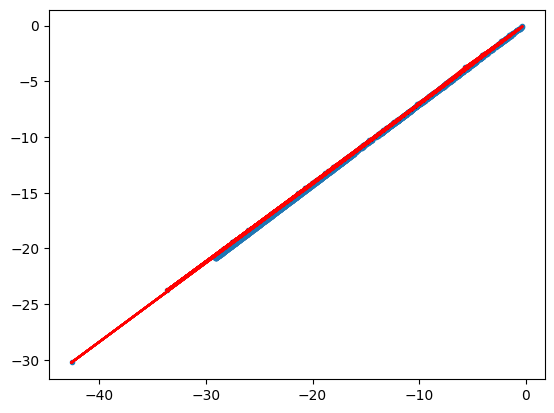

Epoch 140, Loss: 58114540.0


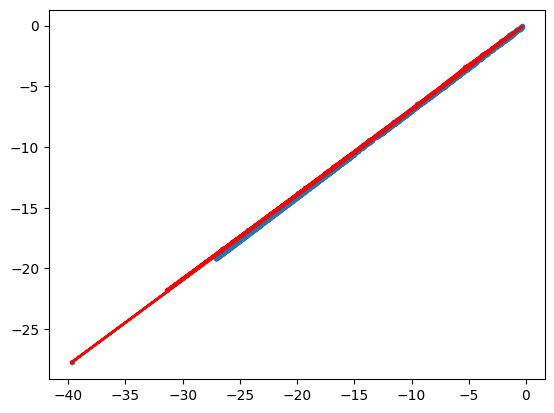

Epoch 160, Loss: 50548688.0


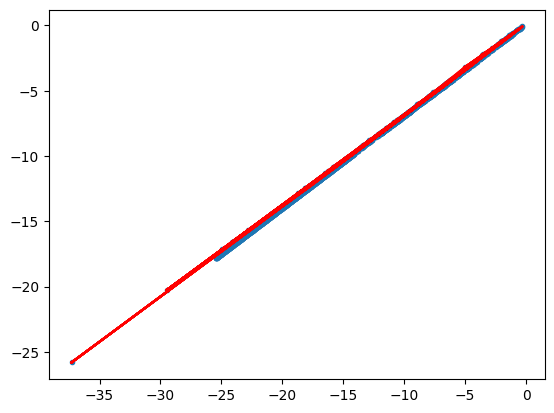

Epoch 180, Loss: 45422432.0


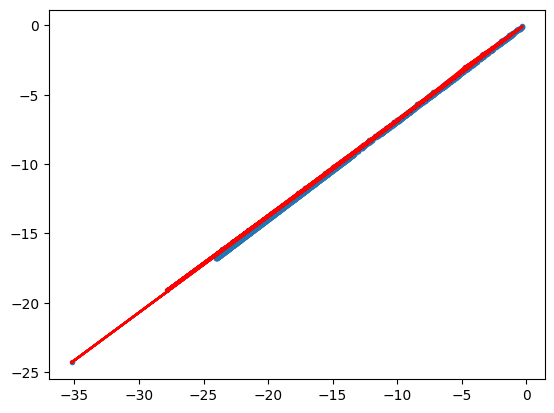

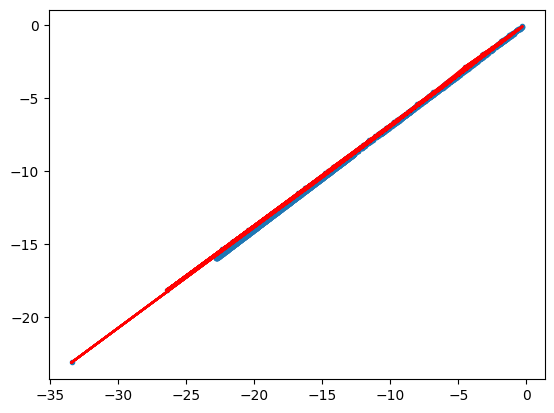

In [66]:
# try again different loss fn:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 200
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = edges_pull_nodes_push(out, data.edge_index, non_connected_pairs)
    # loss = edges_pull(out, data.edge_index)
    loss.backward()
    optimizer.step()
    if epoch % (epochs / 10) == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        plot(out.detach().numpy(), edge_index)

# Forward pass to get the final embeddings
model.eval()
with torch.no_grad():
    out = model(data)
plot(out.detach().numpy(), edge_index)

## Visualization of the result

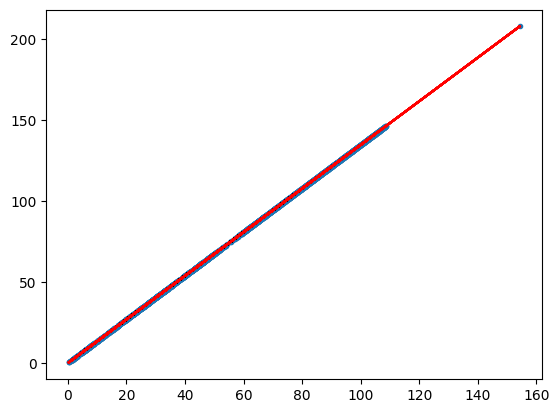

In [31]:
plot(out, edge_index)